In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import strategy.betting_logic as betting_logic
from data.data_prep import DataPrep
from backtest import model_metrics
from data.data_preprocessing import Preprocessor
from features.build_features import FeaturePipeline
from model.train import train_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from backtest import cross_validate
import os
path = r"c:\Users\brtnl\OneDrive\Desktop\code\sports_betting"
os.chdir(path)

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
print("Step 1: Loading data...")
data_prep = DataPrep(dataset="cfb")
raw_data = data_prep.get_data()

print("Step 2: Preprocessing data...")
preprocessor = Preprocessor(raw_data, "total")
odds_df, X, y = preprocessor.preprocess_data()

print("Step 3: Feature engineering...")
feature_pipeline = FeaturePipeline(X)
X = feature_pipeline.engineer_features()

Step 1: Loading data...
Step 2: Preprocessing data...
Step 3: Feature engineering...


In [ ]:
X["week"].unique()

,attendance,away_classification_fbs,away_classification_fcs,away_classification_ii,away_classification_iii,away_conference_acc,away_conference_american_athletic,away_conference_american_rivers,away_conference_american_southwest,away_conference_atlantic_sun,...,home_pregame_elo,latitude,longitude,neutral_site,season,season_type_postseason,season_type_regular,season_type_spring_postseason,season_type_spring_regular,week
id,,,,,,,,,,,,,,,,,,,,,
332412309,20790.0,0,1,0,0,0,0,0,0,0,...,1530.0,41.139094,-81.313460,0,2013,0,1,0,0,1
332410062,39058.0,1,0,0,0,0,0,0,0,0,...,1304.0,21.372801,-157.929965,0,2013,0,1,0,0,1
332410278,33098.0,1,0,0,0,0,1,0,0,0,...,1578.0,36.814353,-119.758009,0,2013,0,1,0,0,1
332412502,0.0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,1,2013,0,1,0,0,1
332410023,13136.0,0,1,0,0,0,0,0,0,0,...,0.0,37.319668,-121.868296,0,2013,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401741208,0.0,0,0,0,1,0,0,0,0,0,...,0.0,29.752199,-95.352415,1,2024,1,0,0,0,1
401680057,0.0,0,1,0,0,0,0,0,0,0,...,0.0,33.154444,-96.835278,1,2024,1,0,0,0,1
401677189,0.0,1,0,0,0,0,0,0,0,0,...,2063.0,25.957967,-80.238860,1,2024,1,0,0,0,1


In [4]:
print("Step 4: Training and evaluating the model...")
model, df = cross_validate(odds_df, X, y, file_name="test_model")

Step 4: Training and evaluating the model...


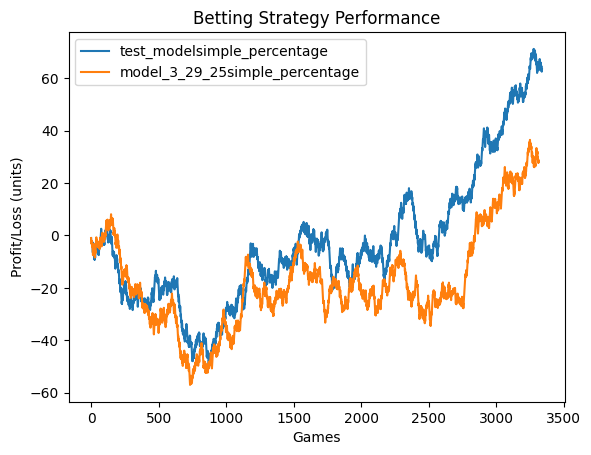

PNL delta from the model: 34.84 units
Model Performance (Booster): test_model
R2 Score:
 -0.002519636963635996
MSE:
 337.4198398194115
MAE:
 14.531395100868252
              Feature  Percentage
183         longitude   15.228837
93   excitement_index    8.806562
182          latitude    7.479678
Model Performance (Booster): model_3_29_25
R2 Score:
 -0.0074874768856887375
MSE:
 340.2940244878765
MAE:
 14.710115652111702
                            Feature  Percentage
1646                      longitude   10.945644
846                excitement_index    7.550946
933   home_postgame_win_probability    5.136872


In [5]:
model_metrics("test_model")